# Exercise: Triangle
The purpose of this exercise is to use flopy and triangle to build a triangular mesh.

In [1]:
import sys
import os
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
from flopy.utils.triangle import Triangle as Triangle
%matplotlib inline


flopy is installed in /Users/mnfienen/Documents/GIT/flopy/flopy


In [2]:
import geopandas as gp

## read a shapefile of Switzerland including the cantons into `geopandas`

In [3]:
ch_cantons = gp.read_file('gadm36_CHE_shp/gadm36_CHE_1.shp')

In [4]:
ch_cantons.geometry

0     POLYGON ((7.94951 47.27751, 7.94897 47.27542, ...
1     POLYGON ((9.20708 47.27694, 9.20828 47.27905, ...
2     MULTIPOLYGON (((9.51250 47.40100, 9.51430 47.4...
3     MULTIPOLYGON (((7.36526 47.41939, 7.36377 47.4...
4     POLYGON ((7.55254 47.54676, 7.55290 47.54829, ...
5     MULTIPOLYGON (((7.09284 46.89419, 7.09202 46.8...
6     MULTIPOLYGON (((6.78575 46.73603, 6.78559 46.7...
7     MULTIPOLYGON (((6.23440 46.33147, 6.23259 46.3...
8     POLYGON ((8.90771 46.80860, 8.90603 46.81009, ...
9     MULTIPOLYGON (((10.22766 46.61207, 10.22734 46...
10    POLYGON ((6.97645 47.36205, 6.93670 47.35773, ...
11    MULTIPOLYGON (((8.47390 47.12135, 8.47540 47.1...
12    POLYGON ((6.46132 46.86218, 6.46295 46.87622, ...
13    MULTIPOLYGON (((8.36748 46.78924, 8.36706 46.7...
14    MULTIPOLYGON (((8.39523 46.77334, 8.39626 46.7...
15    POLYGON ((9.46901 46.90068, 9.46991 46.89828, ...
16    MULTIPOLYGON (((8.85313 47.65377, 8.85196 47.6...
17    POLYGON ((8.42042 47.06653, 8.41810 47.064

## now let's make an outline to use for the whole domain


In [7]:
switzerland_outline = ch_cantons.copy()
switzerland_outline.geometry = switzerland_outline.geometry.convex_hull
switzerland_outline = switzerland_outline.dissolve(by='GID_0')

## now we need to get lists of points to provide to triangle

In [8]:
domainpoly = []
for x,y in zip(switzerland_outline.geometry[0].boundary.xy[0],switzerland_outline.geometry[0].boundary.xy[1]):
    domainpoly.append((float(x), float(y)))
maximum_area = 1

In [9]:
len(switzerland_outline.geometry[0].boundary.xy[0])

189

## make a `triangle` object form which we can build an unstructured grid

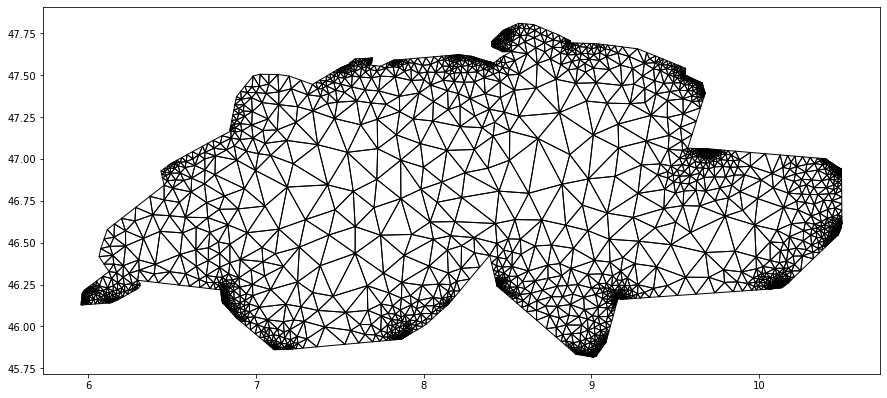

In [10]:
model_ws = './triangle'
if os.path.exists(model_ws):
    shutil.rmtree(model_ws)
os.makedirs(model_ws)

tri = Triangle(maximum_area=maximum_area, angle=33, model_ws=model_ws, 
               exe_name='triangle')
tri.add_polygon(domainpoly)
tri.build(verbose=False)
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1, aspect='equal')
pc = tri.plot(ax=ax)

In [9]:
tri.ncpl

5914

### we can visualize which are the boundary cells 

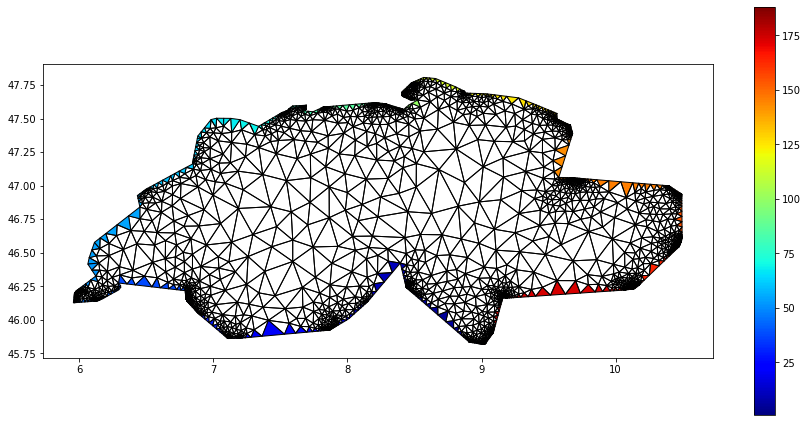

In [10]:
ibd = tri.get_boundary_marker_array()
ibd = np.ma.masked_equal(ibd, 0)
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1, aspect='equal')
pc = tri.plot(a=ibd, cmap='jet')
plt.colorbar(pc, shrink=0.5)

### now find the edges so we can set their constant head values equal to a boundary value

In [11]:
edgenodes = []
for iedge in range(len(domainpoly)):
    nodes = tri.get_edge_cells(iedge)
    for n in nodes:
        if n not in edgenodes:
            edgenodes.append(n)

## now build a modflow model using this grid

In [12]:
name = 'mf'
sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                             exe_name='mf6',
                             sim_ws=model_ws)
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                             perioddata=[[1.0, 1, 1.]])
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='complex', 
                           outer_hclose=1.e-5, inner_hclose=1.e-4)
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
xcyc = tri.get_xcyc()
nlay = 1
ncpl = tri.ncpl
nvert = tri.nvert
top = 1.
hk=0.8
botm = [0.]
dis = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, nvert=nvert,
                               top=top, botm=botm, 
                               vertices=vertices, cell2d=cell2d)
npf = flopy.mf6.ModflowGwfnpf(gwf, k=hk,xt3doptions=[True], 
                              save_specific_discharge=True)
ic = flopy.mf6.ModflowGwfic(gwf)

chdlist = []
for icpl in edgenodes:
    h = 0.
    chdlist.append([(0, icpl), h])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.01)
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord='{}.cbc'.format(name),
                            head_filerecord='{}.hds'.format(name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'LAST')])
sim.write_simulation()
success, buff = sim.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mf...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 885 based on size of stress_period_data
    writing package rcha...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as n

## visualize the head solution

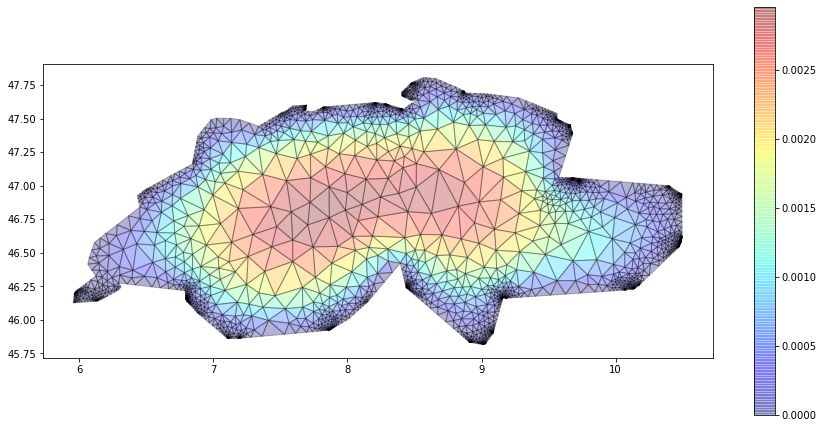

In [13]:
fname = os.path.join(model_ws, name + '.hds')
hdobj = flopy.utils.HeadFile(fname, precision='double')
head = hdobj.get_data()
fname = os.path.join(model_ws, name + '.cbc')
bdobj = flopy.utils.CellBudgetFile(fname, precision='double', verbose=False)
spdis = bdobj.get_data(text='DATA-SPDIS')[0]

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
h=tri.plot(ax=ax, a=head[0, 0, :], cmap='jet', alpha=.3)
plt.colorbar(h, shrink=.5)

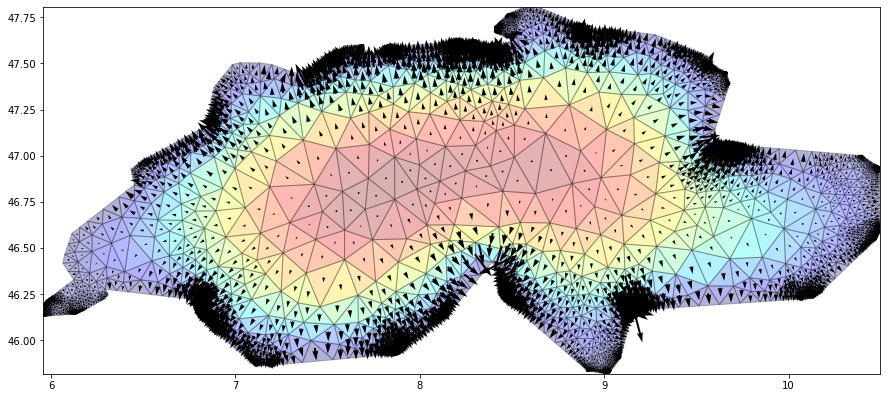

In [14]:
# with vectors
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
pmv.plot_array(head[0, :, :], cmap='jet', edgecolor='0.1', alpha=0.3)
pmv.plot_specific_discharge(spdis)

# More complex geometry options

## first let's make a hole

In [15]:
# note that we can only work with polygon types - not multipolygons

In [16]:
ch_cantons[['NAME_1','geometry']]

,NAME_1,geometry
0,Aargau,"POLYGON ((7.94951 47.27751, 7.94897 47.27542, ..."
1,Appenzell Ausserrhoden,"POLYGON ((9.20708 47.27694, 9.20828 47.27905, ..."
2,Appenzell Innerrhoden,"MULTIPOLYGON (((9.51250 47.40100, 9.51430 47.4..."
3,Basel-Landschaft,"MULTIPOLYGON (((7.36526 47.41939, 7.36377 47.4..."
4,Basel-Stadt,"POLYGON ((7.55254 47.54676, 7.55290 47.54829, ..."
5,Bern,"MULTIPOLYGON (((7.09284 46.89419, 7.09202 46.8..."
6,Fribourg,"MULTIPOLYGON (((6.78575 46.73603, 6.78559 46.7..."
7,Genève,"MULTIPOLYGON (((6.23440 46.33147, 6.23259 46.3..."
8,Glarus,"POLYGON ((8.90771 46.80860, 8.90603 46.81009, ..."
9,Graubünden,"MULTIPOLYGON (((10.22766 46.61207, 10.22734 46..."


# pick a canton to exclude from the grid

In [17]:
hole_poly_df = ch_cantons.loc[ch_cantons.NAME_1=='Schwyz']

## `geopandas` can help us simplify -- we don't want too many points

In [18]:
refine_tolerance = 0.01

1305


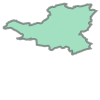

In [19]:
print(len(hole_poly_df.geometry.values[0].boundary.xy[0]))
hole_poly_df.geometry.values[0]

40


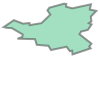

In [20]:
print(len(hole_poly_df.geometry.simplify(refine_tolerance).geometry.values[0].boundary.xy[0]))

hole_poly_df.geometry.simplify(0.01).values[0]

In [21]:
hole_poly_df.geometry = hole_poly_df.geometry.simplify(refine_tolerance)
hole_poly = []
for x,y in zip(hole_poly_df.geometry.values[0].boundary.xy[0],hole_poly_df.geometry.values[0].boundary.xy[1]):
    hole_poly.append((float(x), float(y)))

/Users/mnfienen/anaconda3/envs/pyclass/lib/python3.7/site-packages/geopandas/geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


In [22]:
holexy=hole_poly_df.geometry.centroid

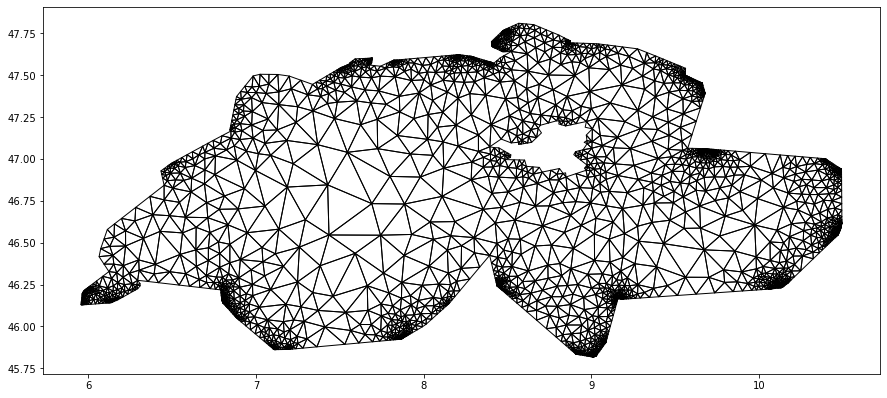

In [23]:
tri = Triangle(maximum_area=maximum_area, angle=33, model_ws=model_ws, 
               exe_name='triangle')
tri.add_polygon(domainpoly)
tri.add_polygon(hole_poly)
tri.add_hole([holexy.x.values,holexy.y.values])
tri.build(verbose=False)
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1, aspect='equal')
tri.plot(ax=ax);

## we can also refine around another polygon

In [24]:
refined_poly_df = ch_cantons.loc[ch_cantons.NAME_1=='Uri'].copy()


1285


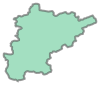

In [25]:
print(len(refined_poly_df.geometry.values[0].boundary.xy[0]))
refined_poly_df.geometry.values[0]

74


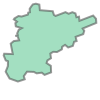

In [26]:
refine_tolerance = 0.005
print(len(refined_poly_df.geometry.simplify(refine_tolerance).values[0].boundary.xy[0]))
refined_poly_df.geometry.simplify(refine_tolerance).values[0]

In [27]:
refined_poly_df.geometry = refined_poly_df.geometry.simplify(.005)

In [28]:
ref_poly = []
for x,y in zip(refined_poly_df.geometry.values[0].boundary.xy[0],refined_poly_df.geometry.values[0].boundary.xy[1]):
    ref_poly.append((float(x), float(y)))

In [29]:
ref_polyxy = refined_poly_df.geometry.centroid

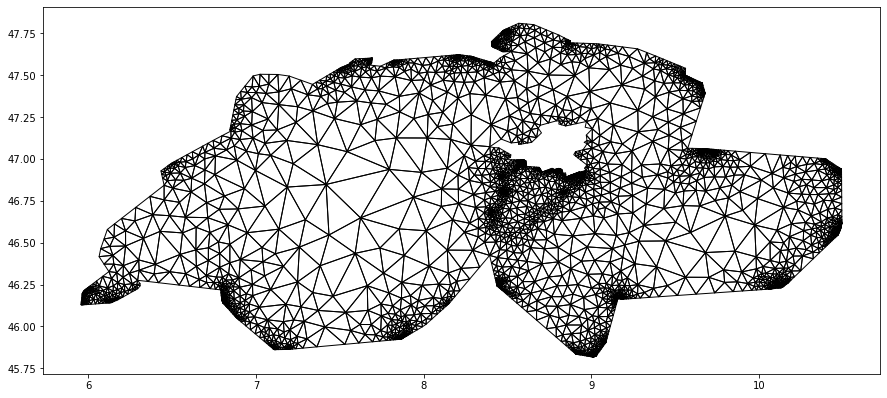

In [30]:
if os.path.exists(model_ws):
    shutil.rmtree(model_ws)
os.makedirs(model_ws)

tri = Triangle(angle=33, model_ws=model_ws, 
               exe_name='triangle')
tri.add_polygon(domainpoly)
tri.add_polygon(hole_poly)
tri.add_polygon(ref_poly)
tri.add_hole([holexy.x.values,holexy.y.values])

tri.add_region([10, 46.5], 1, maximum_area=maximum_area)
tri.add_region((ref_polyxy.x.values[0],ref_polyxy.y.values[0]), 0, maximum_area=maximum_area/10)
tri.build(verbose=False)
fig = plt.figure(figsize=(15,15))
ax = plt.subplot(1, 1, 1, aspect='equal')
tri.plot(ax=ax);

## we will need to add edgenodes for both the main domain and the hole to set boundaries

In [31]:
# first the outer domain
edgenodes = []
for iedge in range(len(domainpoly)):
    nodes = tri.get_edge_cells(iedge)
    for n in nodes:
        if n not in edgenodes:
            edgenodes.append(n)  



In [32]:
# now get the points around the hole
inset_nodes = []
for iedge in range(len(domainpoly),len(domainpoly)+len(hole_poly)):
    nodes = tri.get_edge_cells(iedge)
    for n in nodes:
        if n not in inset_nodes:
            inset_nodes.append(n)    

## now remake the model using the new triangle object for the grid

In [33]:
name = 'mf'
sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                             exe_name='mf6',
                             sim_ws=model_ws)
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                             perioddata=[[1.0, 1, 1.]])
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='complex', 
                           outer_hclose=1.e-5, inner_hclose=1.e-4)
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
xcyc = tri.get_xcyc()
nlay = 1
ncpl = tri.ncpl
nvert = tri.nvert
top = 1.
hk=0.8
botm = [0.]
dis = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, nvert=nvert,
                               top=top, botm=botm, 
                               vertices=vertices, cell2d=cell2d)

In [34]:
npf = flopy.mf6.ModflowGwfnpf(gwf, k = hk, xt3doptions=[True], 
                              save_specific_discharge=True)
ic = flopy.mf6.ModflowGwfic(gwf)

chdlist = []
for icpl in edgenodes:
    h = 10.
    chdlist.append([(0, icpl), h])

for icpl in inset_nodes:
    h = 10.006
    chdlist.append([(0, icpl), h])
    
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.01)
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord='{}.cbc'.format(name),
                            head_filerecord='{}.hds'.format(name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'LAST')])
sim.write_simulation()
success, buff = sim.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mf...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1097 based on size of stress_period_data
    writing package rcha...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as 

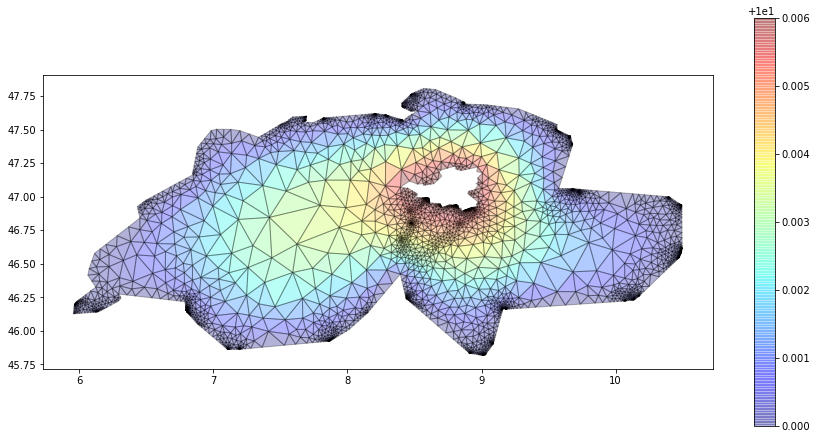

In [35]:
fname = os.path.join(model_ws, name + '.hds')
hdobj = flopy.utils.HeadFile(fname, precision='double')
head = hdobj.get_data()
fname = os.path.join(model_ws, name + '.cbc')
bdobj = flopy.utils.CellBudgetFile(fname, precision='double', verbose=False)
spdis = bdobj.get_data(text='DATA-SPDIS')[0]

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
h=tri.plot(ax=ax, a=head[0, 0, :], cmap='jet', alpha=.3)
plt.colorbar(h, shrink=.5)

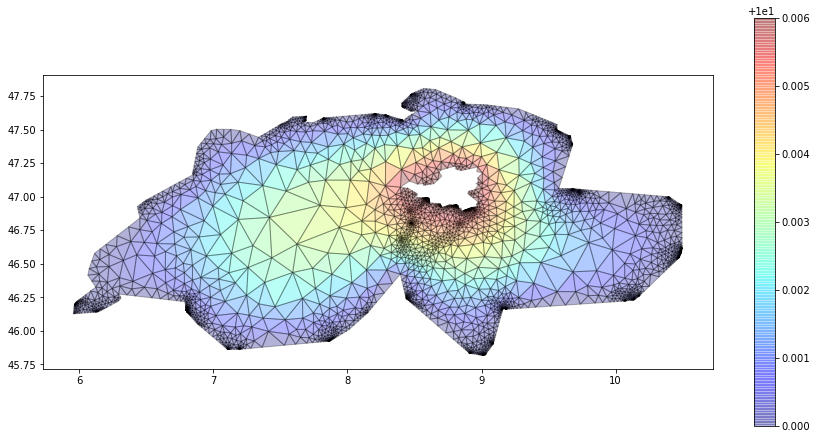

In [36]:
fname = os.path.join(model_ws, name + '.hds')
hdobj = flopy.utils.HeadFile(fname, precision='double')
head = hdobj.get_data()
fname = os.path.join(model_ws, name + '.cbc')
bdobj = flopy.utils.CellBudgetFile(fname, precision='double', verbose=False)
spdis = bdobj.get_data(text='DATA-SPDIS')[0]

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
h=tri.plot(ax=ax, a=head[0, 0, :], cmap='jet', alpha=.3)
plt.colorbar(h, shrink=.5)

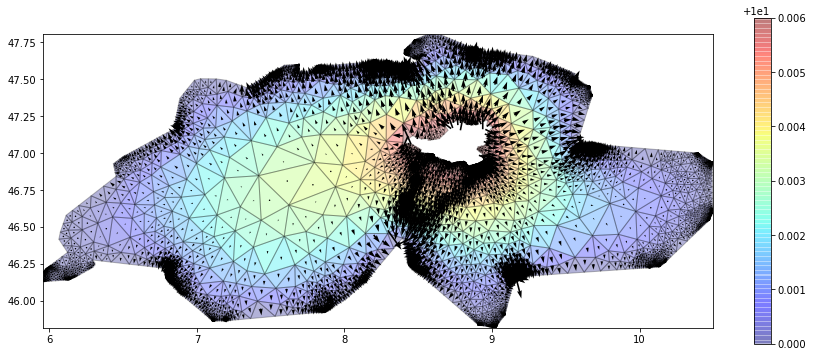

In [37]:
# with vectors
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
h=pmv.plot_array(head[0, :, :], cmap='jet', edgecolor='0.1', alpha=0.3)
pmv.plot_specific_discharge(spdis)
plt.colorbar(h,shrink=0.4)